### COCO数据集

### 随机抽查10%数据

In [6]:
import os
import json
import random
import argparse
from pathlib import Path
from shutil import copy2


def create_mini_coco(input_dir, output_dir, sample_ratio):
    # COCO数据集路径
    annotations_dir = Path(input_dir) / "annotations"
    images_dir_train = Path(input_dir) / "train2017"
    images_dir_val = Path(input_dir) / "val2017"
    
    # 输出目录
    output_annotations_dir = Path(output_dir) / "annotations"
    output_images_dir_train = Path(output_dir) / "train2017"
    output_images_dir_val = Path(output_dir) / "val2017"

    # 确保输出目录存在
    output_annotations_dir.mkdir(parents=True, exist_ok=True)
    output_images_dir_train.mkdir(parents=True, exist_ok=True)
    output_images_dir_val.mkdir(parents=True, exist_ok=True)

    # 处理train和val数据
    for dataset_type, images_dir, output_images_dir in [
        ("train", images_dir_train, output_images_dir_train),
        ("val", images_dir_val, output_images_dir_val),
    ]:
        # 加载annotations文件
        annotation_file = annotations_dir / f"instances_{dataset_type}2017.json"
        with open(annotation_file, "r") as f:
            coco_data = json.load(f)

        # 随机抽样图片
        image_ids = [image["id"] for image in coco_data["images"]]
        sampled_image_ids = set(random.sample(image_ids, int(len(image_ids) * sample_ratio)))

        # 生成新的images和annotations列表
        new_images = [image for image in coco_data["images"] if image["id"] in sampled_image_ids]
        new_annotations = [anno for anno in coco_data["annotations"] if anno["image_id"] in sampled_image_ids]

        # 更新COCO数据结构
        coco_data["images"] = new_images
        coco_data["annotations"] = new_annotations

        # 保存新的annotations文件
        output_annotation_file = output_annotations_dir / f"instances_{dataset_type}2017.json"
        with open(output_annotation_file, "w") as f:
            json.dump(coco_data, f)

        # 拷贝抽样图片到输出目录
        for image in new_images:
            image_file = images_dir / image["file_name"]
            if image_file.exists():
                copy2(image_file, output_images_dir)

    print(f"Mini COCO dataset created successfully in {output_dir}")


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="Create a mini COCO dataset by sampling images and annotations.")
#     parser.add_argument("--input_dir", type=str, required=True, help="Path to the COCO dataset root directory.")
#     parser.add_argument("--output_dir", type=str, required=True, help="Path to the output directory for the mini COCO dataset.")
#     parser.add_argument("--sample_ratio", type=float, default=0.1, help="Sampling ratio for images and annotations (default: 0.1).")
#     args = parser.parse_args()

#     create_mini_coco(args.input_dir, args.output_dir, args.sample_ratio)

# 调用函数
input_dir = "./data/coco"  # 原始COCO数据集目录
output_dir = "./data/mini_coco"  # Mini COCO数据集输出目录
sample_ratio = 0.1  # 抽样比例

create_mini_coco(input_dir, output_dir, sample_ratio)


Mini COCO dataset created successfully in ./data/mini_coco


### 推理10%数据，获得预测结果
<!-- # 推理
!python tools\analyze_wiseiou.py --dataset_path data/mini_coco --output_dir work_dir/wise_iou

# 分析 -->

In [16]:
# 不使用不确定性度量模块
!python -m sual.inference.detector \
    ./checkpoints/1.py \
    ./checkpoints/1.pth \
    ./data/mini_coco/minicoco_img \
    --device cuda:0 \
    --batch-size 4 \
    --num-workers 8 \
    --use-fp16 \
    --output-dir work_dir\wise_iou\mini_coco_detect \
    --score-thr 0.3 \
    --nms-thr 0.3 \
    --max-det 100 \
    --no-uncertainty \
    --vis-scale 1.0

Loads checkpoint by local backend from path: ./checkpoints/1.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

enable_uncertainty value: False

推理完成! 共处理 12328 张图片
结果保存在: work_dir\wise_iou\mini_coco_detect/20241206_033543



Processing images: 100%|██████████| 12328/12328 [33:44<00:00,  6.09it/s]


In [24]:
import os
import json
import math
from pathlib import Path
import numpy as np

def compute_center_error(pred_box, gt_box):
    """
    计算预测框与标注框之间的中心点位置误差
    """
    x_pred_center = (pred_box[0] + pred_box[2]) / 2
    y_pred_center = (pred_box[1] + pred_box[3]) / 2
    x_gt_center = (gt_box[0] + gt_box[2]) / 2
    y_gt_center = (gt_box[1] + gt_box[3]) / 2
    return math.sqrt((x_pred_center - x_gt_center) ** 2 + (y_pred_center - y_gt_center) ** 2)

def nms(bboxes, scores, iou_threshold):
    """
    非极大值抑制 (NMS)
    :param bboxes: [N, 4] 预测框，格式为 [x1, y1, x2, y2]
    :param scores: [N] 预测分数
    :param iou_threshold: IoU 阈值
    :return: NMS 后的索引列表
    """
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return keep

def process_results(pred_dir, coco_annotations_file, output_file, iou_threshold=0.5):
    """
    处理推理结果并计算中心点误差
    """
    # 加载COCO标注数据
    with open(coco_annotations_file, "r") as f:
        coco_data = json.load(f)
    
    # 解析COCO标注数据
    annotations = {anno["image_id"]: [] for anno in coco_data["annotations"]}
    for anno in coco_data["annotations"]:
        annotations[anno["image_id"]].append(anno["bbox"])
    
    # 记录计算结果
    results = {}

    # 遍历预测结果文件夹
    pred_files = [f for f in os.listdir(pred_dir) if f.endswith("_result.json")]
    for pred_file in pred_files:
        image_id = int(pred_file.split("_")[0])  # 提取COCO图片ID
        pred_file_path = Path(pred_dir) / pred_file

        # 加载预测结果
        with open(pred_file_path, "r") as f:
            pred_data = json.load(f)

        # 提取预测框和分数
        pred_bboxes = np.array(pred_data.get("bboxes", []))  # [N, 4]
        scores = np.array(pred_data.get("scores", []))  # [N]
        if len(pred_bboxes) == 0:
            continue

        # 应用NMS
        keep_indices = nms(pred_bboxes, scores, iou_threshold)
        filtered_bboxes = pred_bboxes[keep_indices]
        filtered_scores = scores[keep_indices]

        # 标注框
        gt_bboxes = annotations.get(image_id, [])

        # 计算每对边界框的中心点位置误差
        image_results = []
        for pred_bbox, score in zip(filtered_bboxes, filtered_scores):
            for gt_bbox in gt_bboxes:
                error = compute_center_error(pred_bbox, gt_bbox)
                image_results.append({
                    "pred_bbox": pred_bbox.tolist(),
                    "gt_bbox": gt_bbox,
                    "center_error": error,
                    "score": score
                })

        # 保存结果
        results[image_id] = image_results

    # 保存到输出文件
    with open(output_file, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {output_file}")

# 参数
pred_dir = "./work_dir/wise_iou/mini_coco_detect/20241206_033543/results"  # 推理结果文件夹
coco_annotations_file = "./data/mini_coco/annotations/instances_val2017.json"  # COCO标注文件
output_file = "./work_dir/wise_iou/mini_coco_detect/center_error_results_val.json"  # 输出文件
iou_threshold = 0.7  # IoU 阈值

# 执行计算
process_results(pred_dir, coco_annotations_file, output_file, iou_threshold)


Results saved to ./work_dir/wise_iou/mini_coco_detect/center_error_results_val.json


Histogram saved to ./work_dir/wise_iou/mini_coco_detect/center_error_histogramval0.7.png


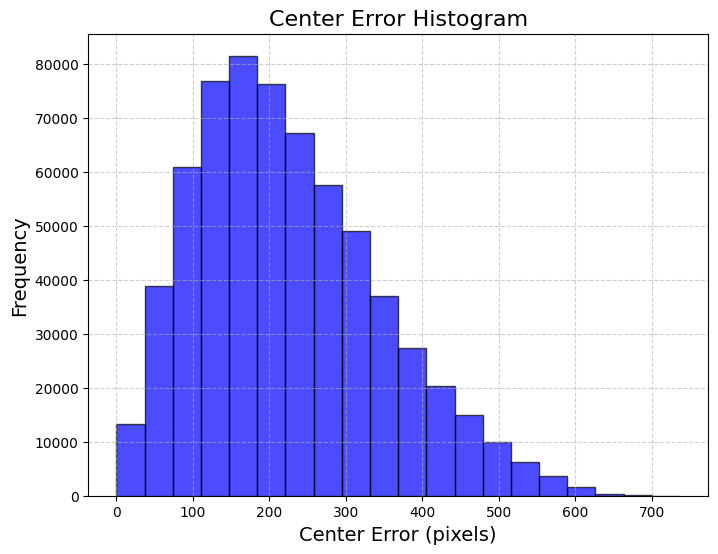

In [25]:
import json
import matplotlib.pyplot as plt

def plot_center_error_histogram(result_file, output_histogram_file=None, bins=20):
    """
    绘制中心误差的直方图
    :param result_file: 中心误差结果的 JSON 文件路径
    :param output_histogram_file: 输出直方图图像的文件路径 (可选)
    :param bins: 直方图的分箱数
    """
    # 加载中心误差结果
    with open(result_file, "r") as f:
        results = json.load(f)
    
    # 收集所有的中心误差
    center_errors = []
    for image_id, image_results in results.items():
        for result in image_results:
            center_errors.append(result["center_error"])

    # 绘制直方图
    plt.figure(figsize=(8, 6))
    plt.hist(center_errors, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title("Center Error Histogram", fontsize=16)
    plt.xlabel("Center Error (pixels)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    
    # 保存或显示直方图
    if output_histogram_file:
        plt.savefig(output_histogram_file, dpi=300)
        print(f"Histogram saved to {output_histogram_file}")
    else:
        plt.show()

# 参数
result_file = "./work_dir/wise_iou/mini_coco_detect/center_error_results_val.json"  # 中心误差 JSON 文件
output_histogram_file = "./work_dir/wise_iou/mini_coco_detect/center_error_histogramval0.7.png"  # 直方图保存路径 (可选)

# 绘制直方图
plot_center_error_histogram(result_file, output_histogram_file)


In [7]:
!python tools\analyze_wiseiou.py --dataset_path data/mini_coco --output_dir work_dir/wise_iou


In [1]:
import os
import shutil

def delete_folder(folder_path):
    """
    删除指定的文件夹，并解除所有可能的文件占用问题。
    :param folder_path: 要删除的文件夹路径
    """
    try:
        # 检查文件夹是否存在
        if os.path.exists(folder_path):
            # 删除文件夹及其内容
            shutil.rmtree(folder_path, ignore_errors=True)
            # 确认删除后再次检查
            if os.path.exists(folder_path):
                print(f"文件夹 {folder_path} 存在占用，尝试逐个文件删除...")
                for root, dirs, files in os.walk(folder_path, topdown=False):
                    for file in files:
                        file_path = os.path.join(root, file)
                        try:
                            os.remove(file_path)
                        except Exception as e:
                            print(f"无法删除文件 {file_path}: {e}")
                    for dir in dirs:
                        dir_path = os.path.join(root, dir)
                        try:
                            os.rmdir(dir_path)
                        except Exception as e:
                            print(f"无法删除文件夹 {dir_path}: {e}")
                # 尝试再次删除文件夹
                os.rmdir(folder_path)
            if not os.path.exists(folder_path):
                print(f"文件夹 {folder_path} 已成功删除！")
            else:
                print(f"文件夹 {folder_path} 删除失败，请检查文件占用情况！")
        else:
            print(f"文件夹 {folder_path} 不存在，无需删除。")
    except Exception as e:
        print(f"删除文件夹 {folder_path} 时发生错误: {e}")



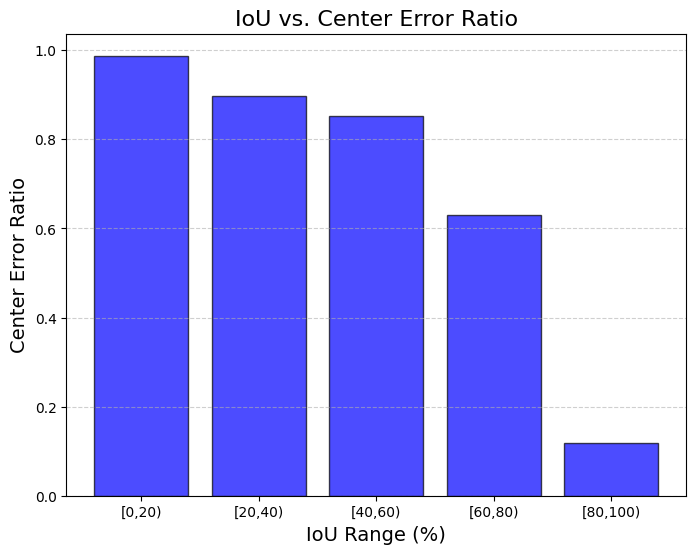

In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt

def compute_iou(bbox1, bbox2):
    """
    计算两个边界框的 IoU
    """
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union_area = bbox1_area + bbox2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def analyze_iou_center_error(result_file, iou_bins, error_threshold):
    """
    分析 IoU 与中心误差的关系
    :param result_file: 推理结果 JSON 文件路径
    :param iou_bins: IoU 区间划分，例如 [0, 20, 40, 60, 80, 100]
    :param error_threshold: 中心误差阈值（如 10 像素）
    """
    with open(result_file, "r") as f:
        results = json.load(f)

    iou_error_counts = {bin_start: 0 for bin_start in iou_bins[:-1]}
    iou_total_counts = {bin_start: 0 for bin_start in iou_bins[:-1]}

    for image_id, image_results in results.items():
        for result in image_results:
            pred_bbox = result["pred_bbox"]
            gt_bbox = result["gt_bbox"]
            center_error = result["center_error"]

            # 计算 IoU
            iou = compute_iou(pred_bbox, gt_bbox) * 100  # 转为百分比

            # 根据 IoU 归类
            for bin_start, bin_end in zip(iou_bins[:-1], iou_bins[1:]):
                if bin_start <= iou < bin_end:
                    iou_total_counts[bin_start] += 1
                    if center_error > error_threshold:
                        iou_error_counts[bin_start] += 1
                    break

    # 计算中心误差占比
    iou_error_ratios = {
        bin_start: (iou_error_counts[bin_start] / iou_total_counts[bin_start] if iou_total_counts[bin_start] > 0 else 0)
        for bin_start in iou_bins[:-1]
    }

    return iou_error_ratios

def plot_iou_center_error(iou_error_ratios, iou_bins):
    """
    绘制 IoU 与中心误差占比的关系
    :param iou_error_ratios: IoU 区间与中心误差占比的映射
    :param iou_bins: IoU 区间划分
    """
    x_labels = [f"[{bin_start},{bin_end})" for bin_start, bin_end in zip(iou_bins[:-1], iou_bins[1:])]
    y_values = [iou_error_ratios[bin_start] for bin_start in iou_bins[:-1]]

    plt.figure(figsize=(8, 6))
    plt.bar(x_labels, y_values, color="blue", alpha=0.7, edgecolor="black")
    plt.xlabel("IoU Range (%)", fontsize=14)
    plt.ylabel("Center Error Ratio", fontsize=14)
    plt.title("IoU vs. Center Error Ratio", fontsize=16)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

# 参数
result_file = "./work_dir/wise_iou/mini_coco_detect/center_error_results_val.json"  # 中心误差 JSON 文件
iou_bins = [0, 20, 40, 60, 80, 100]  # IoU 区间划分
error_threshold = 30  # 中心误差阈值（像素）

# 分析数据
iou_error_ratios = analyze_iou_center_error(result_file, iou_bins, error_threshold)

# 绘制图表
plot_iou_center_error(iou_error_ratios, iou_bins)


### 桉树数据集


#### 尺寸误差

In [3]:
# import os
# import json
# import cv2
# import numpy as np
# from pathlib import Path


# def load_json(json_path):
#     """加载 JSON 文件"""
#     try:
#         with open(json_path, 'r') as f:
#             data = json.load(f)
#         return data
#     except Exception as e:
#         print(f"Error loading JSON file: {json_path}. {e}")
#         return None


# def calculate_iou(box1, box2):
#     """
#     计算两个边界框的 IoU
#     :param box1: [x, y, w, h]
#     :param box2: [x, y, w, h]
#     :return: IoU 值
#     """
#     x1, y1, w1, h1 = box1
#     x2, y2, w2, h2 = box2

#     xi1 = max(x1, x2)
#     yi1 = max(y1, y2)
#     xi2 = min(x1 + w1, x2 + w2)
#     yi2 = min(y1 + h1, y2 + h2)
#     inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

#     box1_area = w1 * h1
#     box2_area = w2 * h2
#     union_area = box1_area + box2_area - inter_area

#     if union_area == 0:
#         return 0
#     return inter_area / union_area


# def generate_colors(num_classes):
#     """
#     生成随机颜色，每个类别一个颜色
#     :param num_classes: 类别总数
#     :return: 类别 ID 到颜色的映射字典
#     """
#     np.random.seed(42)  # 固定随机种子
#     colors = [tuple(np.random.randint(0, 255, size=3).tolist()) for _ in range(num_classes)]
#     return {i: color for i, color in enumerate(colors)}


# def draw_bboxes_with_labels(image, bbox_pairs, output_path, class_colors):
#     """
#     在图片上绘制多个边界框以及标签
#     :param image: 输入图片
#     :param bbox_pairs: [(box1, box2, label1, label2), ...]，包含多个边界框对和对应的标签
#     :param output_path: 保存绘制好的图片路径
#     :param class_colors: 类别 ID 到颜色的映射
#     """
#     for box1, box2, label1, label2 in bbox_pairs:
#         # 绘制第一个框
#         x1, y1, w1, h1 = map(int, box1)
#         color1 = class_colors.get(label1, (0, 255, 0))  # 如果类别未定义颜色，使用默认绿色
#         cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), color1, 2)
#         label1_text = f"{label1}"
#         # label1_text = ""
#         label1_size = cv2.getTextSize(label1_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
#         cv2.rectangle(image, (x1, y1 - label1_size[1] - 4), (x1 + label1_size[0] + 4, y1), color1, -1)
#         cv2.putText(image, label1_text, (x1 + 2, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

#         # 绘制第二个框
#         x2, y2, w2, h2 = map(int, box2)
#         color2 = class_colors.get(label2, (255, 0, 0))  # 如果类别未定义颜色，使用默认蓝色
#         cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), color2, 2)
#         # label2_text = f"Class {label2}"
#         label2_text = f"{label2}"
#         label2_size = cv2.getTextSize(label2_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
#         cv2.rectangle(image, (x2, y2 - label2_size[1] - 4), (x2 + label2_size[0] + 4, y2), color2, -1)
#         cv2.putText(image, label2_text, (x2 + 2, y2 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

#     cv2.imwrite(output_path, image)


# def find_coco_dataset_paths(base_path):
#     """
#     自动找到 COCO 数据集的路径，包括 annotations 和 train2017/val2017
#     """
#     annotations_path = os.path.join(base_path, 'annotations')
#     train_images_path = os.path.join(base_path, 'train2017')
#     val_images_path = os.path.join(base_path, 'val2017')

#     if not os.path.exists(annotations_path):
#         raise FileNotFoundError(f"'annotations' directory not found in {base_path}")
#     if not os.path.exists(train_images_path):
#         raise FileNotFoundError(f"'train2017' directory not found in {base_path}")
#     if not os.path.exists(val_images_path):
#         raise FileNotFoundError(f"'val2017' directory not found in {base_path}")

#     annotation_files = []
#     for filename in ['instances_train2017.json', 'instances_val2017.json']:
#         file_path = os.path.join(annotations_path, filename)
#         if not os.path.exists(file_path):
#             raise FileNotFoundError(f"Annotation file {filename} not found in {annotations_path}")
#         annotation_files.append(file_path)

#     return {
#         "annotations": annotation_files,
#         "train_images": train_images_path,
#         "val_images": val_images_path,
#     }


# def process_coco_dataset(dataset_path, output_dir):
#     """
#     根据 IoU 筛选边界框并将结果保存
#     """
#     dataset_paths = find_coco_dataset_paths(dataset_path)
#     annotation_files = dataset_paths['annotations']
#     images_paths = [dataset_paths['train_images'], dataset_paths['val_images']]

#     output_dir = Path(output_dir)
#     output_dir.mkdir(parents=True, exist_ok=True)

#     # 生成类别颜色映射
#     num_classes = 80  # COCO 数据集类别数量
#     class_colors = generate_colors(num_classes)

#     iou_ranges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
#     iou_folders = [output_dir / f"IOU{int(iou * 100)}" for iou in iou_ranges[:-1]]
#     for folder in iou_folders:
#         folder.mkdir(exist_ok=True)

#     for annotation_file, image_dir in zip(annotation_files, images_paths):
#         coco_data = load_json(annotation_file)
#         if coco_data is None:
#             continue

#         images = {img['id']: img for img in coco_data['images']}
#         annotations = coco_data['annotations']

#         # 遍历所有图片
#         for image_id, image_info in images.items():
#             image_path = os.path.join(image_dir, image_info['file_name'])
#             image_annotations = [(ann['bbox'], ann.get('category_id', 'unknown')) for ann in annotations if ann['image_id'] == image_id]

#             if len(image_annotations) < 2:  # 至少需要两个框才能计算 IoU
#                 continue

#             # 加载图片
#             image = cv2.imread(image_path)
#             if image is None:
#                 print(f"Cannot read image: {image_path}")
#                 continue

#             # 存储每个 IoU 范围的框对
#             iou_bbox_pairs = [[] for _ in range(len(iou_ranges) - 1)]

#             # 计算 IoU
#             for i, (box1, label1) in enumerate(image_annotations):
#                 for (box2, label2) in image_annotations[i + 1:]:
#                     iou = calculate_iou(box1, box2)
#                     for j in range(len(iou_ranges) - 1):
#                         if iou_ranges[j] <= iou < iou_ranges[j + 1]:
#                             iou_bbox_pairs[j].append((box1, box2, label1, label2))

#             # 保存图片
#             for j, bbox_pairs in enumerate(iou_bbox_pairs):
#                 if bbox_pairs:
#                     output_image_path = os.path.join(iou_folders[j], image_info['file_name'])
#                     draw_bboxes_with_labels(image.copy(), bbox_pairs, output_image_path, class_colors)


# # 直接调用函数运行
# if __name__ == "__main__":
#     dataset_path = "data/Eucalyptus_canopy"  # 替换为 COCO 数据集的路径
#     output_dir = "./work_dir/wise_iou_Eucalyptus_canopy"  # 替换为输出目录的路径
#     process_coco_dataset(dataset_path, output_dir)



In [5]:
import os
import json
import cv2
import numpy as np
from pathlib import Path


def load_json(json_path):
    """加载 JSON 文件"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file: {json_path}. {e}")
        return None


def calculate_iou(box1, box2):
    """计算两个边界框的 IoU"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0


def draw_bboxes_with_labels(image, bbox_pairs):
    """
    在图片上绘制多个边界框
    :param image: 输入图片
    :param bbox_pairs: [(box1, box2), ...]
    """
    for box1, box2 in bbox_pairs:
        # 绘制第一个框
        x1, y1, w1, h1 = map(int, box1)
        cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)  # 绿色框

        # 绘制第二个框
        x2, y2, w2, h2 = map(int, box2)
        cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 2)  # 蓝色框


def find_coco_dataset_paths(base_path):
    """自动找到 COCO 数据集的路径"""
    annotations_path = os.path.join(base_path, 'annotations')
    train_images_path = os.path.join(base_path, 'train2017')
    val_images_path = os.path.join(base_path, 'val2017')

    if not os.path.exists(annotations_path):
        raise FileNotFoundError(f"'annotations' directory not found in {base_path}")
    if not os.path.exists(train_images_path):
        raise FileNotFoundError(f"'train2017' directory not found in {base_path}")
    if not os.path.exists(val_images_path):
        raise FileNotFoundError(f"'val2017' directory not found in {base_path}")

    annotation_files = []
    for filename in ['instances_train2017.json', 'instances_val2017.json']:
        file_path = os.path.join(annotations_path, filename)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Annotation file {filename} not found in {annotations_path}")
        annotation_files.append(file_path)

    return {
        "annotations": annotation_files,
        "train_images": train_images_path,
        "val_images": val_images_path,
    }


def process_coco_dataset(dataset_path, output_dir):
    """
    根据 IoU 筛选边界框并将结果保存
    """
    dataset_paths = find_coco_dataset_paths(dataset_path)
    annotation_files = dataset_paths['annotations']
    images_paths = [dataset_paths['train_images'], dataset_paths['val_images']]

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    iou_ranges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    iou_folders = [output_dir / f"IOU{int(iou * 100)}" for iou in iou_ranges[:-1]]
    for folder in iou_folders:
        folder.mkdir(exist_ok=True)

    for annotation_file, image_dir in zip(annotation_files, images_paths):
        coco_data = load_json(annotation_file)
        if coco_data is None:
            continue

        images = {img['id']: img for img in coco_data['images']}
        annotations = coco_data['annotations']

        # 遍历所有图片
        for image_id, image_info in images.items():
            image_path = os.path.join(image_dir, image_info['file_name'])
            image_annotations = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

            if len(image_annotations) < 2:  # 至少需要两个框才能计算 IoU
                continue

            # 加载图片
            image = cv2.imread(image_path)
            if image is None:
                print(f"Cannot read image: {image_path}")
                continue

            # 存储每个 IoU 范围的框对
            iou_bbox_pairs = [[] for _ in range(len(iou_ranges) - 1)]

            # 遍历框对，计算 IoU
            for i, box1 in enumerate(image_annotations):
                for box2 in image_annotations[i + 1:]:
                    iou = calculate_iou(box1, box2)
                    for j in range(len(iou_ranges) - 1):
                        if iou_ranges[j] <= iou < iou_ranges[j + 1]:
                            iou_bbox_pairs[j].append((box1, box2))

            # 按 IoU 范围保存图片
            for j, bbox_pairs in enumerate(iou_bbox_pairs):
                if bbox_pairs:
                    image_copy = image.copy()  # 防止修改原图
                    draw_bboxes_with_labels(image_copy, bbox_pairs)
                    output_image_path = os.path.join(iou_folders[j], image_info['file_name'])
                    cv2.imwrite(output_image_path, image_copy)


# 直接调用函数运行
if __name__ == "__main__":
    dataset_path = "data/Eucalyptus_canopy"  # 替换为 COCO 数据集的路径
    output_dir = "./work_dir/wise_iou_Eucalyptus_canopy"  # 替换为输出目录的路径
    process_coco_dataset(dataset_path, output_dir)


#### 中心点位置误差

In [35]:
import os
import json
import cv2
import math
from pathlib import Path


def load_json(json_path):
    """加载 JSON 文件"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file: {json_path}. {e}")
        return None


def calculate_iou(box1, box2):
    """计算两个边界框的 IoU"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0


# def calculate_center_error(box1, box2):
#     """计算中心位置误差"""
#     cx1, cy1 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
#     cx2, cy2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2
#     center_error = math.sqrt((cx1 - cx2)**2 + (cy1 - cy2)**2)

#     return center_error

def calculate_center_error(box1, box2):
    """计算中心位置误差并进行归一化"""
    cx1, cy1 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
    cx2, cy2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

    # 计算欧氏距离
    euclidean_distance = math.sqrt((cx1 - cx2)**2 + (cy1 - cy2)**2)

    # 计算框的对角线长度
    diagonal1 = math.sqrt(box1[2]**2 + box1[3]**2)
    diagonal2 = math.sqrt(box2[2]**2 + box2[3]**2)

    # 归一化：使用对角线长度的平均值
    normalized_error = euclidean_distance / ((diagonal1 + diagonal2) / 2)

    return normalized_error


def draw_bboxes_with_labels(image, bbox_pairs, color=(0, 255, 0)):
    """在图片上绘制框对"""
    for box1, box2 in bbox_pairs:
        # 绘制两个框
        x1, y1, w1, h1 = map(int, box1)
        x2, y2, w2, h2 = map(int, box2)
        cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), color, 2)
        cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), color, 2)


def process_coco_dataset(dataset_path, output_dir):
    """
    根据 IoU 阈值筛选框对，绘制并保存到不同的文件夹，同时计算中心位置误差
    """
    # 自动匹配 COCO 数据集路径
    annotations_path = os.path.join(dataset_path, 'annotations')
    train_images_path = os.path.join(dataset_path, 'train2017')
    val_images_path = os.path.join(dataset_path, 'val2017')

    annotation_files = [
        os.path.join(annotations_path, 'instances_train2017.json'),
        os.path.join(annotations_path, 'instances_val2017.json')
    ]

    for file_path in annotation_files:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Annotation file not found: {file_path}")

    image_dirs = [train_images_path, val_images_path]
    for image_dir in image_dirs:
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")

    # 定义 IoU 区间和输出文件夹
    iou_ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    iou_folders = [Path(output_dir) / f"IOU{int(start * 100)}-{int(end * 100)}" for start, end in iou_ranges]
    for folder in iou_folders:
        folder.mkdir(parents=True, exist_ok=True)

    # 保存中心位置误差结果
    center_error_results = {f"IOU{int(start * 100)}-{int(end * 100)}": [] for start, end in iou_ranges}

    # 遍历 JSON 文件
    for annotation_file, image_dir in zip(annotation_files, image_dirs):
        coco_data = load_json(annotation_file)
        if coco_data is None:
            continue

        images = {img['id']: img for img in coco_data['images']}
        annotations = coco_data['annotations']

        # 遍历所有图片
        for image_id, image_info in images.items():
            image_path = os.path.join(image_dir, image_info['file_name'])
            image_annotations = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

            if len(image_annotations) < 2:  # 至少需要两个框才能计算 IoU
                continue

            # 加载图片
            image = cv2.imread(image_path)
            if image is None:
                print(f"Cannot read image: {image_path}")
                continue

            # 每个 IoU 范围的框对
            iou_bbox_pairs = {f"IOU{int(start * 100)}-{int(end * 100)}": [] for start, end in iou_ranges}

            # 遍历框对，计算 IoU 和中心位置误差
            for i, box1 in enumerate(image_annotations):
                for box2 in image_annotations[i + 1:]:
                    iou = calculate_iou(box1, box2)
                    if iou <= 0:  # 跳过没有交集的框对
                        continue

                    center_error = calculate_center_error(box1, box2)

                    # 判断 IoU 区间
                    for (start, end), key in zip(iou_ranges, iou_bbox_pairs.keys()):
                        if start <= iou < end:
                            iou_bbox_pairs[key].append((box1, box2))
                            center_error_results[key].append(center_error)

            # 按 IoU 范围保存绘制的图片
            for (start, end), key in zip(iou_ranges, iou_bbox_pairs.keys()):
                if iou_bbox_pairs[key]:
                    image_copy = image.copy()  # 防止修改原图
                    draw_bboxes_with_labels(image_copy, iou_bbox_pairs[key])
                    output_image_path = Path(output_dir) / key / image_info['file_name']
                    cv2.imwrite(str(output_image_path), image_copy)

    # 保存中心误差统计结果
    result_file = Path(output_dir) / "center_error_results.json"
    with open(result_file, 'w') as f:
        json.dump(center_error_results, f, indent=4)

    print(f"中心位置误差统计结果已保存到: {result_file}")

# 主函数
if __name__ == "__main__":
    dataset_path = "data/Eucalyptus_canopy"  # 替换为您的数据集根目录
    output_dir = "./output"  # 输出目录
    process_coco_dataset(dataset_path, output_dir)
    


中心位置误差统计结果已保存到: output\center_error_results.json


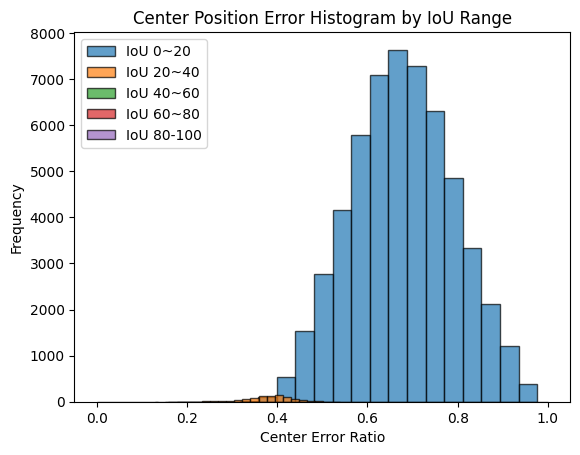

中心位置误差直方图已保存到: output\center_error_histogram.png


In [66]:
import json
import matplotlib.pyplot as plt
import numpy as np

def load_json(json_path):
    """加载 JSON 文件"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file: {json_path}. {e}")
        return None

def plot_center_error_histogram(center_error_results, output_path):
    """
    绘制中心位置误差的直方图
    :param center_error_results: 中心位置误差的数据字典
    :param output_path: 输出图像文件的路径
    """
    # 为每个 IoU 范围绘制一个直方图
    for iou_range, errors in center_error_results.items():
        # 将误差转换为 NumPy 数组并计算直方图
        errors = np.array(errors)
        
        # 绘制直方图
        plt.hist(errors, bins=20, alpha=0.7, label=iou_range, edgecolor='black')

    # 设置标题和标签
    plt.title('Center Position Error Histogram by IoU Range')
    plt.xlabel('Center Error Ratio')
    plt.ylabel('Frequency')

    # 添加图例
    plt.legend()

    # 保存图像
    plt.savefig(output_path)
    plt.show()

if __name__ == "__main__":
    # 加载之前保存的 center_error_results.json 文件
    json_path = 'output\center_error_results.json'
    center_error_results = load_json(json_path)

    if center_error_results:
        # 输出图像的路径
        output_path = 'output\center_error_histogram.png'
        plot_center_error_histogram(center_error_results, output_path)
        print(f"中心位置误差直方图已保存到: {output_path}")


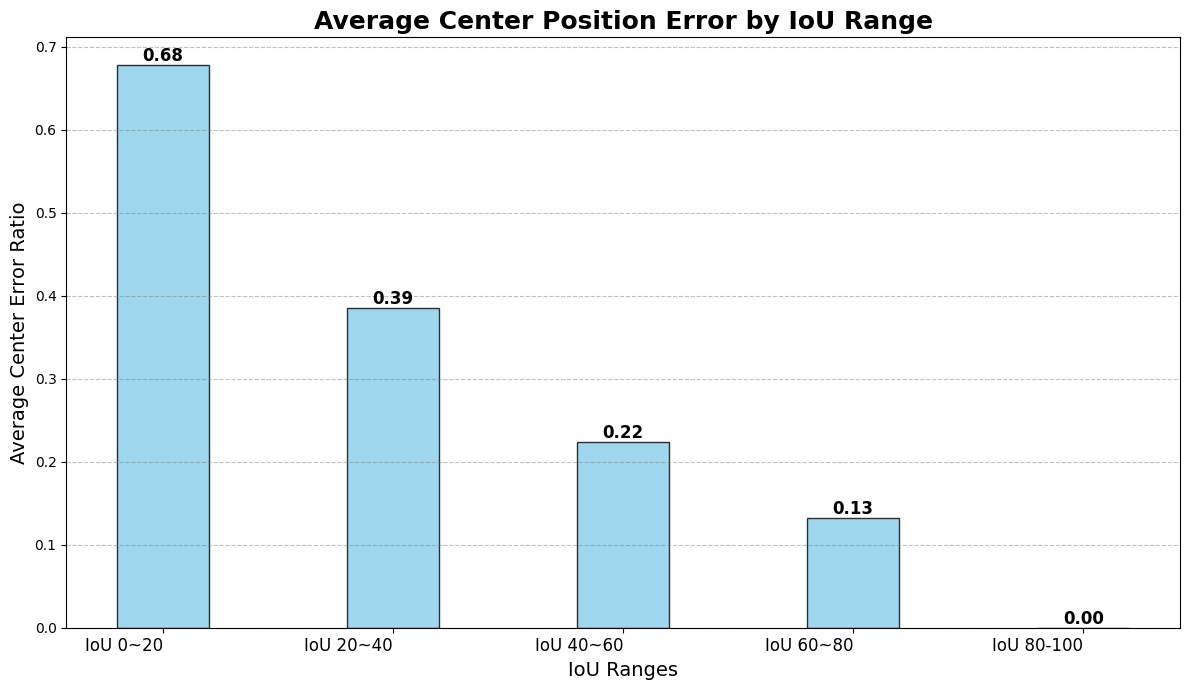

中心位置误差条形图已保存到: ./output/center_error_by_iou_range.png


In [74]:
import json
import matplotlib.pyplot as plt
import numpy as np

def load_json(json_path):
    """加载 JSON 文件"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file: {json_path}. {e}")
        return None

def plot_center_error_by_iou_ranges(center_error_results, output_path):
    """
    绘制中心位置误差的条形图，横坐标为 IoU 范围
    :param center_error_results: 中心位置误差的数据字典
    :param output_path: 输出图像文件的路径
    """
    iou_ranges = list(center_error_results.keys())  # IoU 范围作为横坐标
    avg_errors = []

    # 计算每个 IoU 范围的平均中心误差
    for iou_range, errors in center_error_results.items():
        if errors:  # 确保有数据
            avg_errors.append(np.mean(errors))
        else:
            avg_errors.append(0)

    # 绘制条形图
    bar_width = 0.4
    x_positions = np.arange(len(iou_ranges))  # x 坐标位置
    plt.figure(figsize=(12, 7))  # 调整图像大小
    bars = plt.bar(x_positions, avg_errors, width=bar_width, color='skyblue', edgecolor='black', alpha=0.8)

    # 添加 x 轴标签，并调整间距
    plt.xticks(ticks=x_positions, labels=iou_ranges, fontsize=12, rotation=0, ha='right')

    # 在每个柱状图上显示平均值
    for bar, avg in zip(bars, avg_errors):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{avg:.2f}',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

    # 设置标题和标签
    plt.title('Average Center Position Error by IoU Range', fontsize=18, fontweight='bold')
    plt.xlabel('IoU Ranges', fontsize=14)
    plt.ylabel('Average Center Error Ratio', fontsize=14)

    # 添加网格线（灰色）
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

    # 自动调整布局以避免标签重叠
    plt.tight_layout()

    # 保存图像
    plt.savefig(output_path)
    plt.show()

if __name__ == "__main__":
    # 加载之前保存的 center_error_results.json 文件
    json_path = 'output/center_error_results.json'
    center_error_results = load_json(json_path)

    if center_error_results:
        # 输出图像的路径
        output_path = './output/center_error_by_iou_range.png'
        plot_center_error_by_iou_ranges(center_error_results, output_path)
        print(f"中心位置误差条形图已保存到: {output_path}")


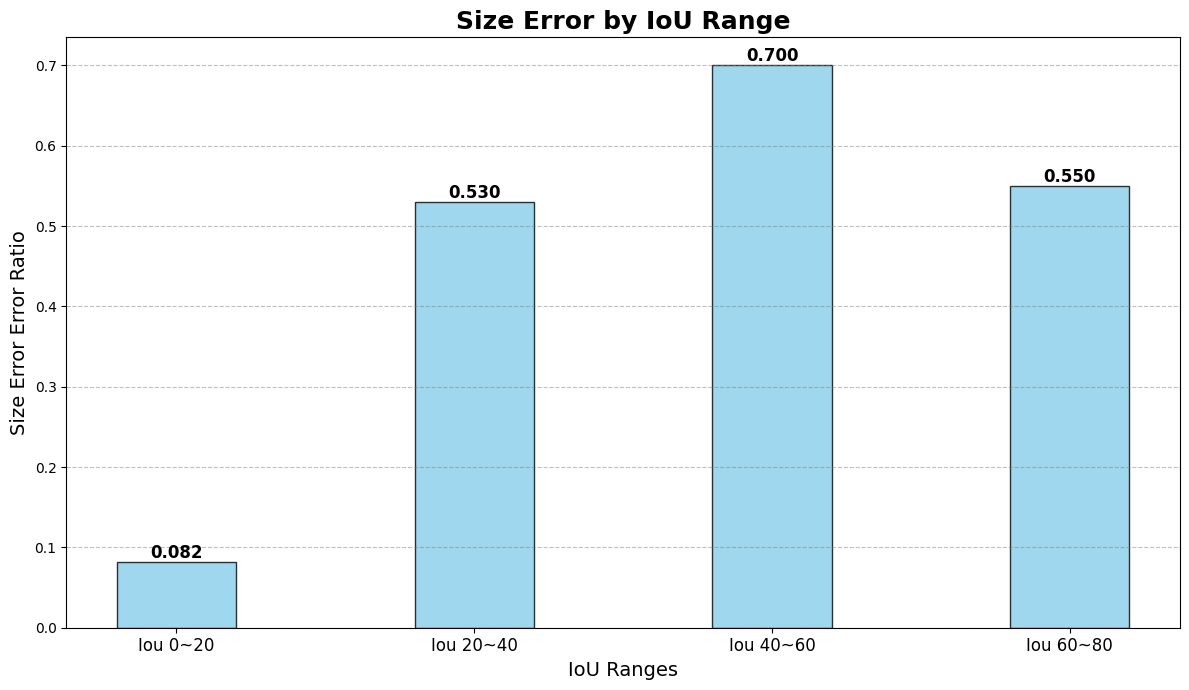

条形图已保存到: ./output/size_error_by_iou_range.png


In [75]:
import matplotlib.pyplot as plt
import numpy as np

def plot_center_error_by_iou_ranges(center_error_results, output_path):
    """
    绘制边界框 IoU 范围与尺寸误差占比的条形图
    :param center_error_results: IoU 范围和尺寸误差占比的数据字典
    :param output_path: 输出图像文件的路径
    """
    iou_ranges = list(center_error_results.keys())  # IoU 范围作为横坐标
    avg_errors = list(center_error_results.values())  # 尺寸误差占比作为纵坐标

    # 绘制条形图
    bar_width = 0.4
    x_positions = np.arange(len(iou_ranges))  # x 坐标位置
    plt.figure(figsize=(12, 7))  # 调整图像大小
    bars = plt.bar(x_positions, avg_errors, width=bar_width, color='skyblue', edgecolor='black', alpha=0.8)

    # 添加 x 轴标签，并调整间距
    plt.xticks(ticks=x_positions, labels=iou_ranges, fontsize=12, rotation=0, ha='center')

    # 在每个柱状图上显示平均值
    for bar, avg in zip(bars, avg_errors):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{avg:.3f}',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

    # 设置标题和标签
    # plt.title('Bounding Box IoU Ranges vs Size Error Ratio', fontsize=18, fontweight='bold')
    # plt.xlabel('Bounding Box IoU Ranges', fontsize=14)
    # plt.ylabel('Size Error Ratio (%)', fontsize=14)
    plt.title('Size Error by IoU Range', fontsize=18, fontweight='bold')
    plt.xlabel('IoU Ranges', fontsize=14)
    plt.ylabel('Size Error Error Ratio', fontsize=14)

    # 添加网格线（灰色）
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

    # 自动调整布局以避免标签重叠
    plt.tight_layout()

    # 保存图像
    plt.savefig(output_path)
    plt.show()

if __name__ == "__main__":
    # 定义数据
    center_error_results = {
        'Iou 0~20': 0.082,
        'Iou 20~40': 0.53,
        'Iou 40~60': 0.7,
        'Iou 60~80': 0.55
    }

    # 输出图像的路径
    output_path = './output/size_error_by_iou_range.png'
    plot_center_error_by_iou_ranges(center_error_results, output_path)
    print(f"条形图已保存到: {output_path}")


In [ ]:
# import os
# import json
# import cv2
# import math
# from pathlib import Path


# def load_json(json_path):
#     """加载 JSON 文件"""
#     try:
#         with open(json_path, 'r') as f:
#             return json.load(f)
#     except Exception as e:
#         print(f"Error loading JSON file: {json_path}. {e}")
#         return None


# def calculate_center_error(box1, box2):
#     """计算中心位置误差并归一化"""
#     cx1, cy1 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
#     cx2, cy2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

#     # 计算欧氏距离
#     euclidean_distance = math.sqrt((cx1 - cx2)**2 + (cy1 - cy2)**2)

#     # 计算框的对角线长度
#     diagonal1 = math.sqrt(box1[2]**2 + box1[3]**2)
#     diagonal2 = math.sqrt(box2[2]**2 + box2[3]**2)

#     # 归一化：使用对角线长度的平均值
#     normalized_error = euclidean_distance / ((diagonal1 + diagonal2) / 2)

#     return normalized_error


# def calculate_scale_error(box1, box2):
#     """计算尺度误差占比"""
#     area1 = box1[2] * box1[3]
#     area2 = box2[2] * box2[3]
#     return abs(area1 - area2) / max(area1, area2)


# def draw_bboxes_with_labels(image, bbox_pairs, color=(0, 255, 0)):
#     """在图片上绘制框对"""
#     for box1, box2 in bbox_pairs:
#         # 绘制两个框
#         x1, y1, w1, h1 = map(int, box1)
#         x2, y2, w2, h2 = map(int, box2)
#         cv2.rectangle(image, (x1, y1), (x1 + w1, y1 + h1), color, 2)
#         cv2.rectangle(image, (x2, y2), (x2 + w2, y2 + h2), color, 2)


# def process_bbox_by_size(dataset_path, output_dir):
#     """
#     根据边界框尺寸（像素面积）筛选框对，绘制并保存到不同文件夹，同时计算误差占比
#     """
#     # 自动匹配数据集路径
#     annotations_path = os.path.join(dataset_path, 'annotations')
#     train_images_path = os.path.join(dataset_path, 'train2017')
#     val_images_path = os.path.join(dataset_path, 'val2017')

#     annotation_files = [
#         os.path.join(annotations_path, 'instances_train2017.json'),
#         os.path.join(annotations_path, 'instances_val2017.json')
#     ]

#     for file_path in annotation_files:
#         if not os.path.exists(file_path):
#             raise FileNotFoundError(f"Annotation file not found: {file_path}")

#     image_dirs = [train_images_path, val_images_path]
#     for image_dir in image_dirs:
#         if not os.path.exists(image_dir):
#             raise FileNotFoundError(f"Image directory not found: {image_dir}")

#     # 定义尺寸区间和输出文件夹
#     size_ranges = [(100, 400), (400, 900), (900, 1600), (1600, 2500), (2500, 3600)]
#     size_folders = [Path(output_dir) / f"Size{min_size}-{max_size}" for min_size, max_size in size_ranges]
#     for folder in size_folders:
#         folder.mkdir(parents=True, exist_ok=True)

#     # 保存误差统计结果
#     scale_error_results = {f"Size{min_size}-{max_size}": [] for min_size, max_size in size_ranges}
#     center_error_results = {f"Size{min_size}-{max_size}": [] for min_size, max_size in size_ranges}

#     # 遍历 JSON 文件
#     for annotation_file, image_dir in zip(annotation_files, image_dirs):
#         coco_data = load_json(annotation_file)
#         if coco_data is None:
#             continue

#         images = {img['id']: img for img in coco_data['images']}
#         annotations = coco_data['annotations']

#         # 遍历所有图片
#         for image_id, image_info in images.items():
#             image_path = os.path.join(image_dir, image_info['file_name'])
#             image_annotations = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

#             if len(image_annotations) < 2:  # 至少需要两个框
#                 continue

#             # 加载图片
#             image = cv2.imread(image_path)
#             if image is None:
#                 print(f"Cannot read image: {image_path}")
#                 continue

#             # 每个尺寸范围的框对
#             size_bbox_pairs = {f"Size{min_size}-{max_size}": [] for min_size, max_size in size_ranges}

#             # 遍历框对，计算尺寸范围和误差
#             for i, box1 in enumerate(image_annotations):
#                 for box2 in image_annotations[i + 1:]:
#                     area1 = box1[2] * box1[3]
#                     area2 = box2[2] * box2[3]

#                     # 判断尺寸范围
#                     for (min_size, max_size), key in zip(size_ranges, size_bbox_pairs.keys()):
#                         if min_size <= area1 <= max_size and min_size <= area2 <= max_size:
#                             size_bbox_pairs[key].append((box1, box2))
#                             scale_error_results[key].append(calculate_scale_error(box1, box2))
#                             center_error_results[key].append(calculate_center_error(box1, box2))

#             # 按尺寸范围保存绘制的图片
#             for (min_size, max_size), key in zip(size_ranges, size_bbox_pairs.keys()):
#                 if size_bbox_pairs[key]:
#                     image_copy = image.copy()  # 防止修改原图
#                     draw_bboxes_with_labels(image_copy, size_bbox_pairs[key])
#                     output_image_path = Path(output_dir) / key / image_info['file_name']
#                     cv2.imwrite(str(output_image_path), image_copy)

#     # 保存误差统计结果
#     scale_result_file = Path(output_dir) / "scale_error_results.json"
#     center_result_file = Path(output_dir) / "center_error_results.json"
#     with open(scale_result_file, 'w') as f:
#         json.dump(scale_error_results, f, indent=4)
#     with open(center_result_file, 'w') as f:
#         json.dump(center_error_results, f, indent=4)

#     print(f"尺度误差统计结果已保存到: {scale_result_file}")
#     print(f"中心位置误差统计结果已保存到: {center_result_file}")


# # 主函数
# if __name__ == "__main__":
#     dataset_path = "data/Eucalyptus_canopy"  # 替换为您的数据集根目录
#     output_dir = "./outputss"  # 输出目录
#     process_bbox_by_size(dataset_path, output_dir)


In [70]:
# import os
# import json
# import cv2
# from pathlib import Path


# def load_json(json_path):
#     """加载 JSON 文件"""
#     try:
#         with open(json_path, 'r') as f:
#             return json.load(f)
#     except Exception as e:
#         print(f"Error loading JSON file: {json_path}. {e}")
#         return None


# def process_bbox_by_size(dataset_path, output_dir):
#     """
#     根据边界框尺寸（像素面积）筛选框，保存到不同文件夹
#     """
#     # 自动匹配数据集路径
#     annotations_path = os.path.join(dataset_path, 'annotations')
#     train_images_path = os.path.join(dataset_path, 'train2017')
#     val_images_path = os.path.join(dataset_path, 'val2017')

#     annotation_files = [
#         os.path.join(annotations_path, 'instances_train2017.json'),
#         os.path.join(annotations_path, 'instances_val2017.json')
#     ]

#     for file_path in annotation_files:
#         if not os.path.exists(file_path):
#             raise FileNotFoundError(f"Annotation file not found: {file_path}")

#     image_dirs = [train_images_path, val_images_path]
#     for image_dir in image_dirs:
#         if not os.path.exists(image_dir):
#             raise FileNotFoundError(f"Image directory not found: {image_dir}")

#     # 定义尺寸区间和输出文件夹
#     size_ranges = [
#         (225, 400), (400, 900), (900, 1600),
#         (1600, 2500), (2500, 3600), (3600, 6400)
#     ]
#     size_folders = [Path(output_dir) / f"Size{min_size}-{max_size}" for min_size, max_size in size_ranges]
#     for folder in size_folders:
#         folder.mkdir(parents=True, exist_ok=True)

#     # 遍历 JSON 文件
#     for annotation_file, image_dir in zip(annotation_files, image_dirs):
#         coco_data = load_json(annotation_file)
#         if coco_data is None:
#             continue

#         images = {img['id']: img for img in coco_data['images']}
#         annotations = coco_data['annotations']

#         # 遍历所有图片
#         for image_id, image_info in images.items():
#             image_path = os.path.join(image_dir, image_info['file_name'])
#             image_annotations = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

#             # 加载图片
#             image = cv2.imread(image_path)
#             if image is None:
#                 print(f"Cannot read image: {image_path}")
#                 continue

#             # 每个尺寸范围的框
#             size_bbox_groups = {f"Size{min_size}-{max_size}": [] for min_size, max_size in size_ranges}

#             # 遍历框，计算面积并按范围分类
#             for box in image_annotations:
#                 area = box[2] * box[3]  # 计算面积
#                 for (min_size, max_size), key in zip(size_ranges, size_bbox_groups.keys()):
#                     if min_size <= area <= max_size:
#                         size_bbox_groups[key].append(box)

#             # 按尺寸范围保存绘制的图片
#             for (min_size, max_size), key in zip(size_ranges, size_bbox_groups.keys()):
#                 if size_bbox_groups[key]:
#                     image_copy = image.copy()  # 防止修改原图
#                     for box in size_bbox_groups[key]:
#                         x, y, w, h = map(int, box)
#                         cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
#                     output_image_path = Path(output_dir) / key / image_info['file_name']
#                     cv2.imwrite(str(output_image_path), image_copy)

#     print(f"边界框尺寸处理完成，结果保存在: {output_dir}")


# # 主函数
# if __name__ == "__main__":
#     dataset_path = "data/Eucalyptus_canopy"  # 替换为您的数据集根目录
#     output_dir = "./output"  # 输出目录
#     process_bbox_by_size(dataset_path, output_dir)

import os
import json
import cv2
from pathlib import Path


def load_json(json_path):
    """加载 JSON 文件"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading JSON file: {json_path}. {e}")
        return None


def process_bbox_by_size(dataset_path, output_dir):
    """
    根据边界框尺寸（像素面积）筛选框，保存到不同文件夹，并标注总框数量
    """
    # 自动匹配数据集路径
    annotations_path = os.path.join(dataset_path, 'annotations')
    train_images_path = os.path.join(dataset_path, 'train2017')
    val_images_path = os.path.join(dataset_path, 'val2017')

    annotation_files = [
        os.path.join(annotations_path, 'instances_train2017.json'),
        os.path.join(annotations_path, 'instances_val2017.json')
    ]

    for file_path in annotation_files:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Annotation file not found: {file_path}")

    image_dirs = [train_images_path, val_images_path]
    for image_dir in image_dirs:
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")

    # 定义尺寸区间和输出文件夹
    size_ranges = [
        (225, 400), (400, 900), (900, 1600),
        (1600, 2500), (2500, 3600), (3600, 6400)
    ]
    size_folders = [Path(output_dir) / f"Size{min_size}-{max_size}" for min_size, max_size in size_ranges]
    for folder in size_folders:
        folder.mkdir(parents=True, exist_ok=True)

    # 遍历 JSON 文件
    for annotation_file, image_dir in zip(annotation_files, image_dirs):
        coco_data = load_json(annotation_file)
        if coco_data is None:
            continue

        images = {img['id']: img for img in coco_data['images']}
        annotations = coco_data['annotations']

        # 遍历所有图片
        for image_id, image_info in images.items():
            image_path = os.path.join(image_dir, image_info['file_name'])
            image_annotations = [ann['bbox'] for ann in annotations if ann['image_id'] == image_id]

            # 加载图片
            image = cv2.imread(image_path)
            if image is None:
                print(f"Cannot read image: {image_path}")
                continue

            # 每个尺寸范围的框
            size_bbox_groups = {f"Size{min_size}-{max_size}": [] for min_size, max_size in size_ranges}

            # 遍历框，计算面积并按范围分类
            for box in image_annotations:
                area = box[2] * box[3]  # 计算面积
                for (min_size, max_size), key in zip(size_ranges, size_bbox_groups.keys()):
                    if min_size <= area <= max_size:
                        size_bbox_groups[key].append(box)

            # 按尺寸范围保存绘制的图片
            for (min_size, max_size), key in zip(size_ranges, size_bbox_groups.keys()):
                if size_bbox_groups[key]:
                    image_copy = image.copy()  # 防止修改原图
                    for box in size_bbox_groups[key]:
                        x, y, w, h = map(int, box)
                        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    # 添加红色文字标注总框数量
                    total_bboxes = len(size_bbox_groups[key])
                    text = f"Total Bboxes: {total_bboxes}"
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.8
                    color = (0, 0, 255)  # 红色
                    thickness = 2
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_x = 10
                    text_y = image_copy.shape[0] - 10
                    cv2.putText(image_copy, text, (text_x, text_y), font, font_scale, color, thickness)

                    # 保存图片
                    output_image_path = Path(output_dir) / key / image_info['file_name']
                    cv2.imwrite(str(output_image_path), image_copy)

    print(f"边界框尺寸处理完成，结果保存在: {output_dir}")


# 主函数
if __name__ == "__main__":
    dataset_path = "data/Eucalyptus_canopy"  # 替换为您的数据集根目录
    output_dir = "./output"  # 输出目录
    process_bbox_by_size(dataset_path, output_dir)



边界框尺寸处理完成，结果保存在: ./output


In [71]:
import os
import random
from pathlib import Path
import shutil


def sample_images_from_folders(input_dir, output_dir, num_samples=10):
    """
    从以 "Size" 开头的子文件夹中随机抽取指定数量的图片，并另存到新文件夹
    :param input_dir: 输入文件夹路径
    :param output_dir: 输出文件夹路径
    :param num_samples: 每个文件夹抽取的图片数量
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    # 遍历输入文件夹的每个子文件夹
    for subfolder in input_path.iterdir():
        if not subfolder.is_dir() or not subfolder.name.startswith("Size"):
            # 跳过非文件夹或不以 "Size" 开头的文件夹
            continue

        # 获取子文件夹中的所有文件
        all_files = list(subfolder.glob("*.*"))
        if not all_files:
            print(f"文件夹为空，跳过: {subfolder}")
            continue

        # 随机抽取指定数量的文件
        sampled_files = random.sample(all_files, min(num_samples, len(all_files)))

        # 创建对应的输出子文件夹
        target_subfolder = output_path / subfolder.name
        target_subfolder.mkdir(parents=True, exist_ok=True)

        # 复制抽取的文件到目标文件夹
        for file in sampled_files:
            shutil.copy(file, target_subfolder)

        print(f"从文件夹 {subfolder} 抽取了 {len(sampled_files)} 张图片到 {target_subfolder}")


# 主函数
if __name__ == "__main__":
    input_directory = "./output"  # 替换为包含图片的输入文件夹路径
    output_directory = "./output/sampled_output"  # 替换为抽取后的目标文件夹路径
    sample_images_from_folders(input_directory, output_directory, num_samples=10)


从文件夹 output\Size1600-2500 抽取了 10 张图片到 output\sampled_output\Size1600-2500
从文件夹 output\Size225-400 抽取了 10 张图片到 output\sampled_output\Size225-400
从文件夹 output\Size2500-3600 抽取了 10 张图片到 output\sampled_output\Size2500-3600
从文件夹 output\Size3600-6400 抽取了 10 张图片到 output\sampled_output\Size3600-6400
从文件夹 output\Size400-900 抽取了 10 张图片到 output\sampled_output\Size400-900
从文件夹 output\Size900-1600 抽取了 10 张图片到 output\sampled_output\Size900-1600


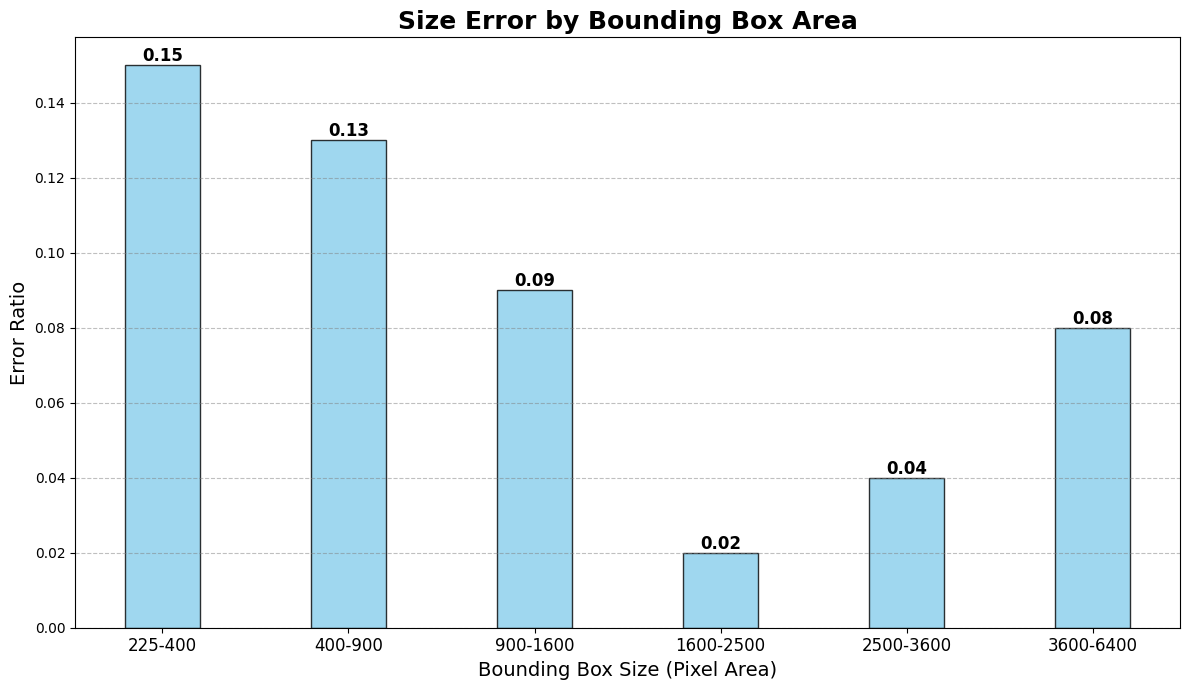

条形图已保存到: ./output/size_error_by_bbox_area.png


In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_size_error_by_bbox_ranges(size_error_results, output_path):
    """
    绘制边界框尺寸范围与尺度误差占比的条形图
    :param size_error_results: 边界框尺寸范围和尺度误差占比的数据字典
    :param output_path: 输出图像文件的路径
    """
    size_ranges = list(size_error_results.keys())  # 尺寸范围作为横坐标
    error_ratios = list(size_error_results.values())  # 尺度误差占比作为纵坐标

    # 绘制条形图
    bar_width = 0.4
    x_positions = np.arange(len(size_ranges))  # x 坐标位置
    plt.figure(figsize=(12, 7))  # 调整图像大小
    bars = plt.bar(x_positions, error_ratios, width=bar_width, color='skyblue', edgecolor='black', alpha=0.8)

    # 添加 x 轴标签，并调整间距
    plt.xticks(ticks=x_positions, labels=size_ranges, fontsize=12, rotation=0, ha='center')

    # 在每个柱状图上显示误差比例
    for bar, ratio in zip(bars, error_ratios):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f'{ratio:.2f}',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

    # 设置标题和标签
    plt.title('Size Error by Bounding Box Area', fontsize=18, fontweight='bold')
    plt.xlabel('Bounding Box Size (Pixel Area)', fontsize=14)
    plt.ylabel('Error Ratio', fontsize=14)

    # 添加网格线（灰色）
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

    # 自动调整布局以避免标签重叠
    plt.tight_layout()

    # 保存图像
    plt.savefig(output_path)
    plt.show()

if __name__ == "__main__":
    # 定义数据
    size_error_results = {
        '225-400': 0.15,
        '400-900': 0.13,
        '900-1600': 0.09,
        '1600-2500': 0.02,
        '2500-3600': 0.04,
        '3600-6400': 0.08
    }

    # 输出图像的路径
    output_path = './output/size_error_by_bbox_area.png'
    plot_size_error_by_bbox_ranges(size_error_results, output_path)
    print(f"条形图已保存到: {output_path}")
